In [ ]:
%pip install -q bitsandbytes>=0.39.0 \
                 git+https://github.com/huggingface/accelerate.git \
                 git+https://github.com/huggingface/transformers.git

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
torch.manual_seed(0)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


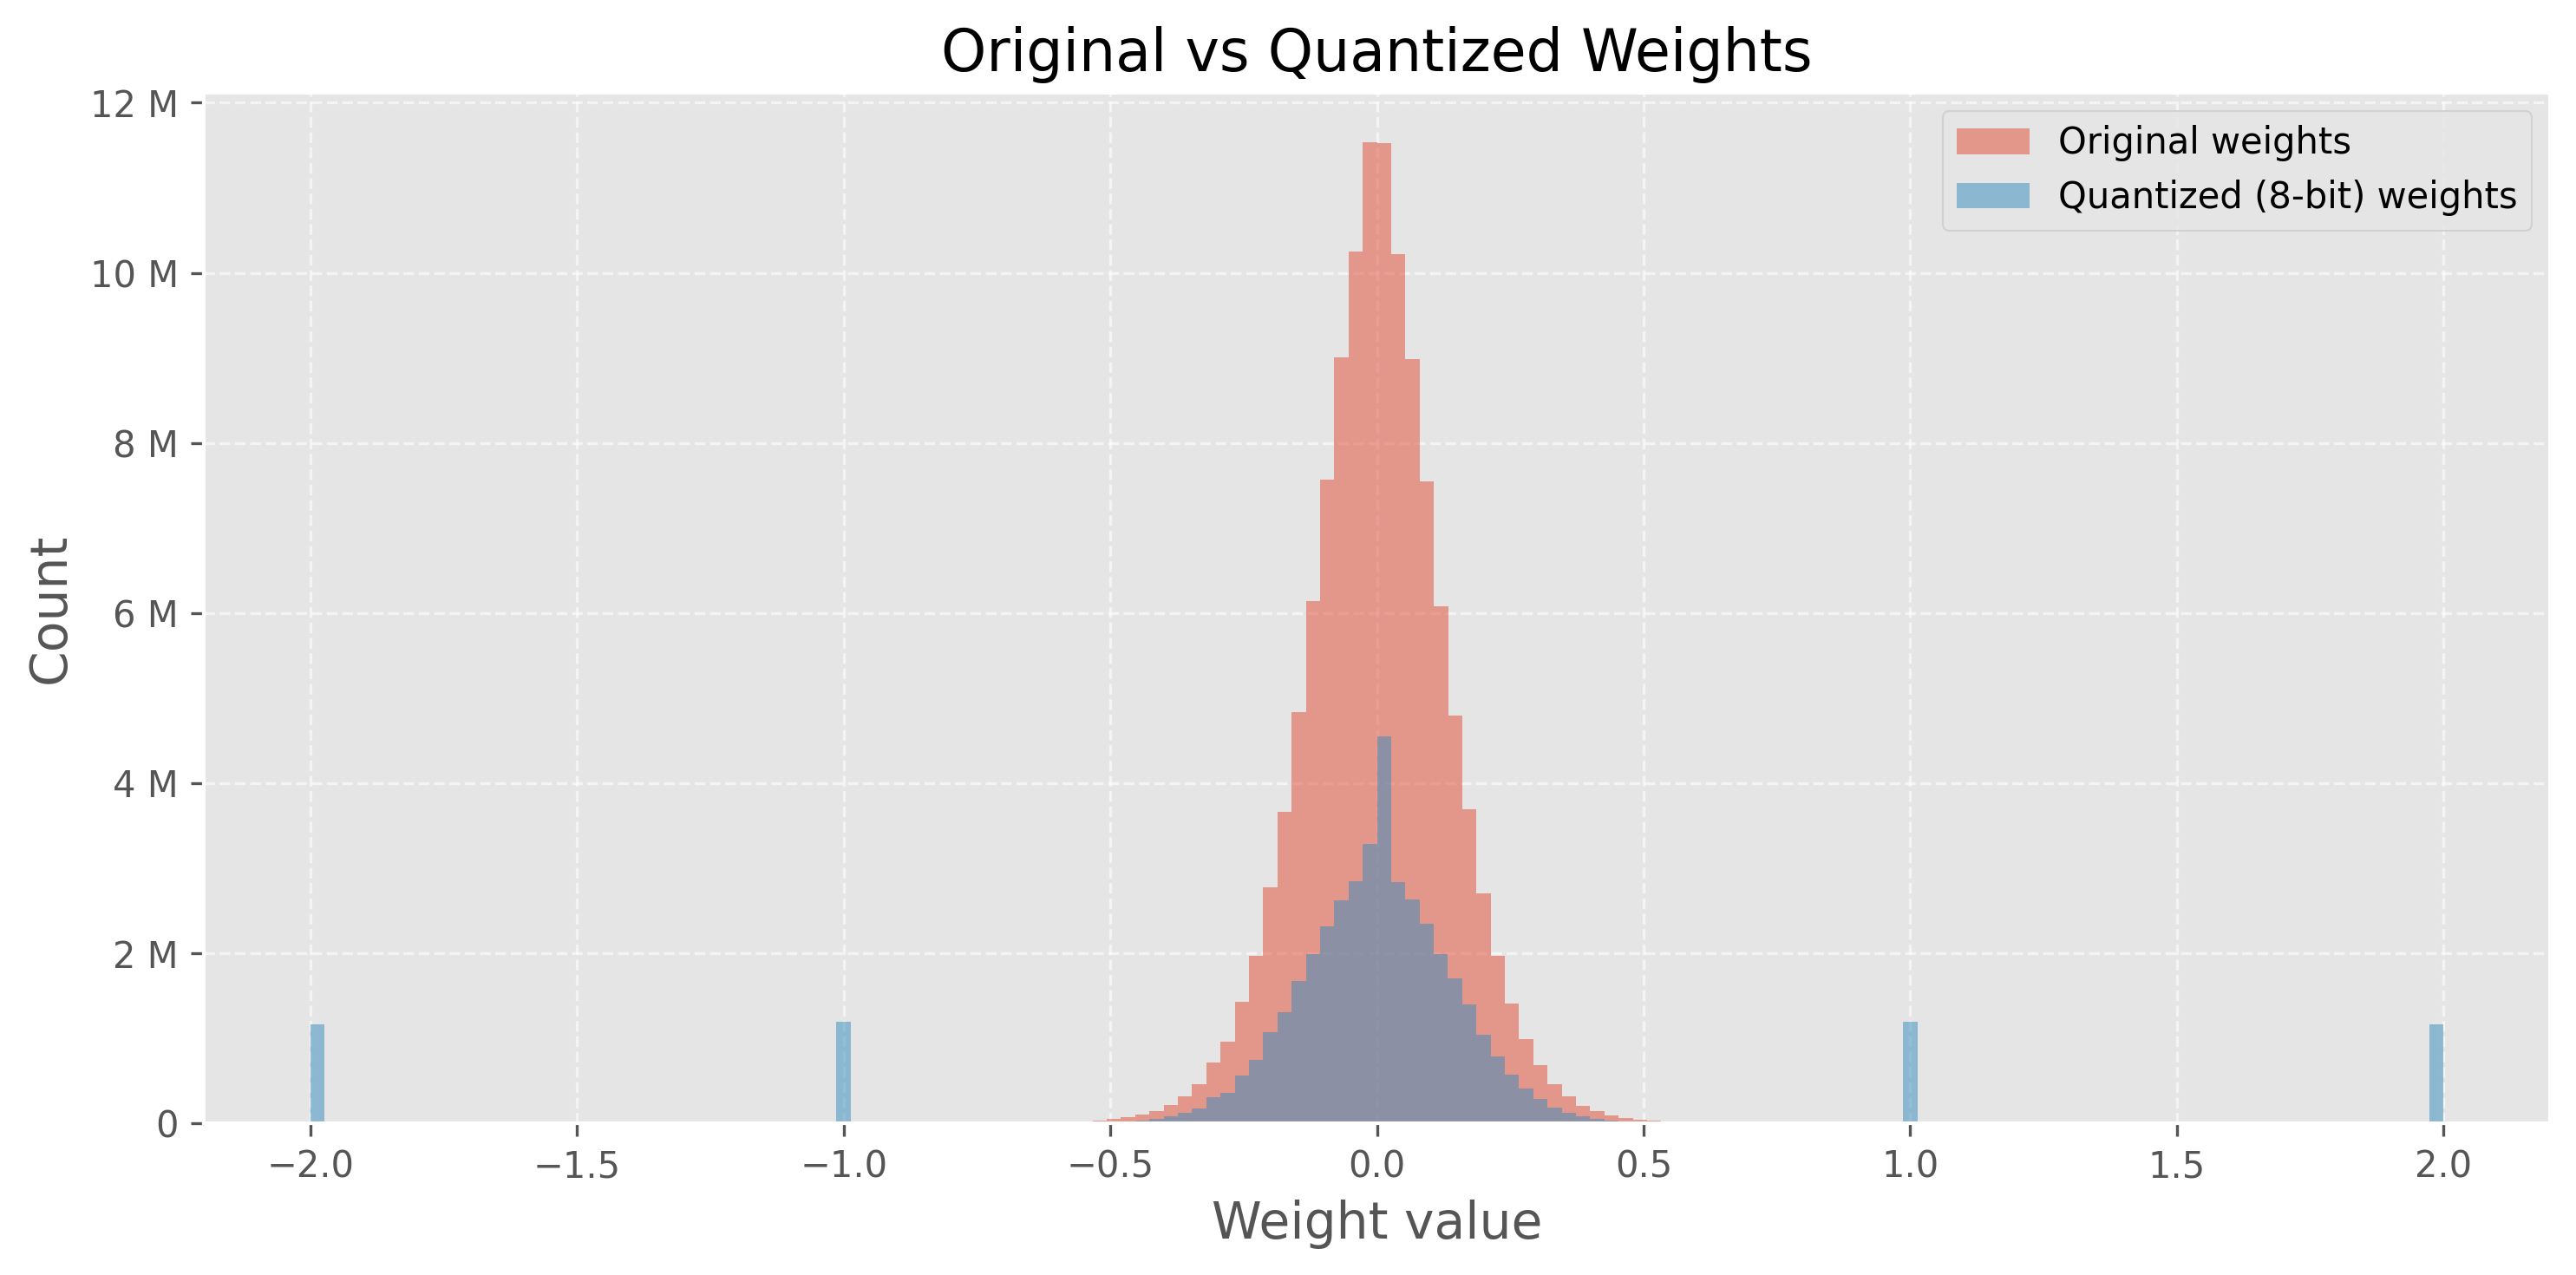

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = 'gpt2'

# load fp32
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
# load int8
model_int8 = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    load_in_8bit=True,
)

# flatten & concat weights
weights_fp32 = np.concatenate([
    p.data.cpu().numpy().flatten() for p in model.parameters()
])
weights_int8 = np.concatenate([
    p.data.cpu().numpy().flatten() for p in model_int8.parameters()
])

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
ax.hist(weights_fp32, bins=150, alpha=0.5,
        label='Original weights', range=(-2,2))
ax.hist(weights_int8, bins=150, alpha=0.5,
        label='Quantized (8‑bit) weights', range=(-2,2))
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
ax.set_title('Original vs Quantized Weights', fontsize=16)
ax.set_xlabel('Weight value', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.tight_layout()
plt.show()

In [ ]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")

In [ ]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have a dream. I don't know what will come of it, but I am going to have to look for something that will be right. I haven't thought about it for a long time, but I have to try to get that thing
--------------------------------------------------
LLM.int8() model:
I have a dream job.

If you can't get your work done, you could be at a loss for words...

What's a dream job like?

There's a big one ahead of you.

How to


In [ ]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

In [ ]:
ppl     = calculate_perplexity(model, original_text)
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Perplexity (original):   7.94
Perplexity (LLM.int8()): 9.03
